# Analysis of Centrin, Rab6, and FRM2 signal areas in interphase and dividing parasites

## Workflow
1. Load packages and confirm working directory for relative paths
2. Process data
    - Replace values of 275.188 with None
        - where the AND of two ROI's returned nothing i.e. there is no overlap
    - Replace values of 0 with None
        - Where the given column's condition was not measured in that image.
3. Calculate % overlap between centrin, rab6, and frm2 (see below)
4. Plot data


% overlaps are calculated as:
$$
\small \text{Where }\land \text{ represents the logical AND operator, or the intersection of two sets.} \\
\small \text{Let:} \\
\small \quad C = \text{Area of Centrin1 signal in } \mu m^2 \\
\small \quad F = \text{Area of FRM2 signal in } \mu m^2 \\
\small \quad R = \text{Area of Rab6 signal in } \mu m^2 \\
\begin {align*}
\small \text{Centrin1/Rab6 Overlap} = \frac {C \land R}{C \cup R} \times 100 \\
\small \text{FRM2/Centrin1 Overlap} = \frac {C \land F}{C \cup F} \times 100 \\ 
\small \text{FRM2/Rab6 Overlap} = \frac {F \land R}{F \cup R} \times 100 \\
\end {align*}
$$


In [102]:
import os  # file paths
import pandas as pd  # dataframes
import scipy.stats as stats  # statistics
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # plotting
import copy # for making deep copies
import numpy as np

# set working directory for relative file paths
if not os.getcwd().endswith("frm2"):
    print(f'current wd: {os.getcwd()}\n\tnot "frm2/", changing ...')
    os.chdir("..")
    print(f"new wd: {os.getcwd()}")
else:
    print(f"wd: {os.getcwd()}")

wd: c:\Users\jak-w\OneDrive - University of Connecticut\1-Projects\frm2


In [103]:
# load in csv
raw_csv_path = "results/.csv/2024-12-07_frm2-gfp_centrin1_mapple-rab6_overlap.csv"
raw_df = pd.read_csv(raw_csv_path)
raw_df.head(0)

,img,cell_cycle,centrin_area,rab_area,formin_area,centrin-rab_overlap,centrin-formin_overlap,formin-rab_overlap,all_overlap


In [104]:
exp_dict = {
    '2024-09-30_frm2-gfp_centrin1_mapple-rab6': 1,
    '2024-08-04_frm2-gfp_centrin1_imc1-mcherry': 2,
    '2024-08-04_frm2-gfp_centrin1_mch-tubulin': 3,
    '2024-08-04_frm2-gfp_mapple-rab6': 4,
    '2024-08-29_frm2-gfp_centrin1_mch-tubulin': 5,
    '2024-09-30_frm2-gfp_mapple-rab6': 6,
}

def get_experiment(img: str):
    # Remove the last 3 characters to match the keys in the dictionary
    experiment = img[:-3]
    # Use the dictionary to find the experiment number
    experiment_number = exp_dict.get(experiment, None)
    return experiment_number


In [105]:
pd.set_option('future.no_silent_downcasting', True)
# Converting no overlap conditions to None
df = copy.deepcopy(raw_df)
df = df.replace(0, None)
df = df.replace(275.188, 0)

# Calculating percent overlaps
percent_df = copy.deepcopy(df[["img", "cell_cycle"]])
percent_df["Centrin1/Rab6"] = (
    df["centrin-rab_overlap"] / (df["centrin_area"] + df["rab_area"])
) * 100
percent_df["FRM2/Centrin1"] = (
    df["centrin-formin_overlap"] / (df["centrin_area"] + df["formin_area"])
) * 100
percent_df["FRM2/Rab6"] = (
    df["formin-rab_overlap"] / (df["formin_area"] + df["rab_area"])
) * 100
percent_df["Centrin1/FRM2/Rab6"] = (
    df["all_overlap"] / (df["centrin_area"] + df["formin_area"] + df["rab_area"])
) * 100
# Melting to long format
melted_df = percent_df.melt(
    id_vars=["img", "cell_cycle"], var_name="overlap_type", value_name="percent"
)
melted_df["cell_cycle_num"] = melted_df["cell_cycle"].map(
    {"Interphase": 0, "Division": 1}
)
melted_df["experiment"] = melted_df["img"].apply(get_experiment)
melted_df = melted_df.dropna()

# for statistics
stat_df = melted_df[["experiment", "overlap_type", "cell_cycle", "percent"]]
mean_df = stat_df.groupby(["overlap_type", "cell_cycle", "experiment"], as_index=False)["percent"].mean()

# for plotting
plot_df = copy.deepcopy(melted_df)

c:\Users\jak-w\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\jak-w\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\jak-w\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


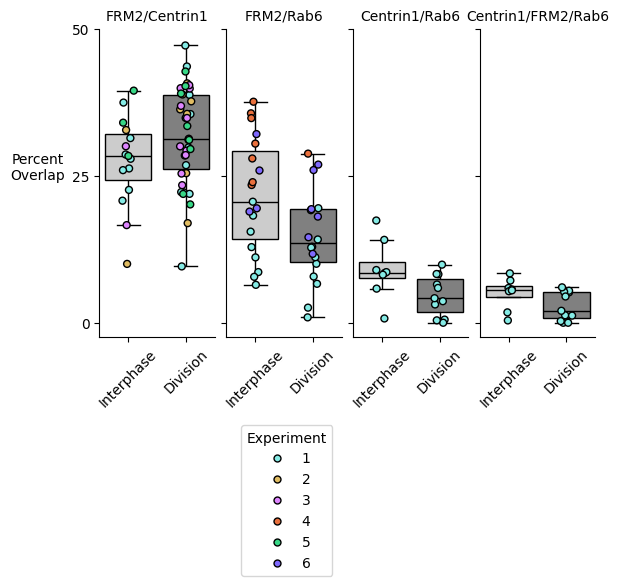

In [ ]:
def customize_ticks(ticks, n_ticks=3):
    maximum = max(ticks)
    min_y, max_y = 0, np.round(maximum, 1)
    custom_ticks = np.linspace(min_y, max_y, n_ticks)
    return custom_ticks

custom_cycle_order = ["Interphase", "Division"]
plot_df["cell_cycle"] = pd.Categorical(
    plot_df["cell_cycle"], categories=custom_cycle_order, ordered=True
)
exp_pal = sns.cubehelix_palette(
    n_colors=len(plot_df["experiment"].unique()),
    start=3,
    rot=6,
    gamma=1,
    hue=2,
    light=0.8,
    dark=0.5,
)
col_pal = sns.cubehelix_palette(
    n_colors=2,
    start=0,
    rot=0.5,
    gamma=1,
    hue=0,
    light=0.8,
    dark=0.5,
)
unique_experiments = plot_df["experiment"].unique()
exp_pal = {experiment: exp_pal[i] for i, experiment in enumerate(unique_experiments)}
categories = plot_df["cell_cycle"].unique()
# Create the FacetGrid
g = sns.FacetGrid(
    data=plot_df,
    col="overlap_type",
    col_order=["FRM2/Centrin1", "FRM2/Rab6", "Centrin1/Rab6", "Centrin1/FRM2/Rab6"],
    height=4,
    aspect=0.4,
    gridspec_kws={"wspace": 0.1, "hspace": 0.1}
)
# Map the box plot to the grid and add legend
g.map_dataframe(
    sns.boxplot,
    order=categories,
    x="cell_cycle",
    y="percent",
    hue="cell_cycle",
    palette=col_pal,
    showfliers=False,
    linecolor="black",
)
# Overlay the strip plot with the same order and different hue and add legend
g.map_dataframe(
    sns.stripplot,
    data=plot_df,
    order=categories,
    x="cell_cycle",
    y="percent",
    hue="experiment",
    palette=exp_pal,
    edgecolor="black",
    linewidth=1,
    size=5,
)
# Combine legends manually for both hues
handles, labels = [], []
for ax in g.axes.flatten():
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    handles.extend(ax_handles)
    labels.extend(ax_labels)

# Remove duplicate labels and ensure correct order
unique_labels = {label: handle for label, handle in zip(labels, handles)}
sorted_labels = sorted(unique_labels.keys(), reverse=False)
sorted_handles = [unique_labels[label] for label in sorted_labels]
g.fig.legend(
    sorted_handles, 
    sorted_labels, 
    title="Experiment", 
    loc="center right",
    bbox_to_anchor=(0.5,-0.3),
)

# Set custom y ticks
all_ticks = []
for ax in g.axes.flatten():
    all_ticks.extend(ax.get_yticks())
global_custom_ticks = customize_ticks(all_ticks)
for ax in g.axes.flatten():
    ax.set_yticks(global_custom_ticks)

# Customize titles for each facet
g.set_titles("{col_name}")
g.set_xlabels("")
g.set_xticklabels(rotation=45)
g.set_ylabels("Percent\nOverlap", rotation=0, labelpad=25)

plt.show()
